# Explore the language of characters in J. Austen's novels

In [315]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd


## Introduction

In 1987 J.F. Burrows published his computational study on the language of the characters in the 6 complete novels of Jane Austen ([*Computation into Criticism*](https://archive.org/details/computationintoc0000burr), Oxford University Press, 1987). We will talk again about Burrows’ methodology and results.

In his introduction, the author discusses the great amount of work (it was 1987!) required to prepare the data to support his intended analyses. Burrows’ team had to tag the full text of Austen’s novels, by marking information on a series of linguistic aspects (e.g. multiwords, mentions of persons, disambiguation of POSs, like $to_{conjunction}$ vs $to_{preposition}$). But in particular, Burrows had the direct speech (with character attribution) marked into the text.

Eventually, these tagged texts were made publicly available. They are currently distributed by the Oxford Text Archive ([OTA](https://ota.bodleian.ox.ac.uk/repository/xmlui/)), which is also part of [CLARIN-UK](https://www.clarin.ac.uk/oxford-text-archive).

[This](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1227), for instance, is the data page for *Mansfield Park*. The following is a snippet of how the data are encoded:

```tsv
101:  3, 1'  !| It is a truth universally acknowledged, that$3$ a single man
101:  3, 2'  !| in possession of a good fortune, must be in want$0$ of a wife.
101:  3, 3'  !| However little known the feelings or views of such a
101:  3, 4'  !| man may$1$ be on$4$ his first entering a neighbourhood, this
101:  3, 5'  !| truth is so$5#1$ well$9$ fixed in the minds of the surrounding
101:  3, 6'  !| families, that$3$ he is considered as the rightful property of
101:  3, 7'  !| some one or other of their daughters.
101:  3, 8D  !| "My dear$2#1$ $PP#C$Mr%*Bennet,"
101:  3, 8'  !| said his lady to$4$ him one day,
101:  3, 9D  !| "have you heard that$3$ Netherfield*Park is let at last$0$?"
101:  3,10'  !| $PP#C$Mr%*Bennet replied that$3$ he had not.
101:  3,11D  !| "But it is,"
101:  3,11'  !| returned she;


```

Although I have worked quite a bit with Burrows' analyses (see [here](https://classics-at.chs.harvard.edu/the-syntax-of-the-heroes-a-treebank-based-approach-to-the-language-of-the-sophoclean-characters/) for instance), I have *just* discovered this dataset!

For today's class I have done a (quick and dirty) extraction of the direct speeches, so that we can apply some of the simple exploratory and analytical techniques that we discussed so far to get a glimpse of how the characters talk in JA's novels and of what. I have prepared two dataframes: one with every line in the encoded files, with a code representing the speaking character, and a dataframe with some metadata about the characters (including, first and foremost, the decoding of the character codes like `3A` used by Burrows). These metadata were derived from the calculations printed in the tables of the "Appendix C" of *Computation into Criticism" (Burrows 1987: 228-246)

We will talk again about more in-depth stylistic analyses!

## Load and preprocess

First, we load the CSV file with the lines and speakers in a pandas DataFrame

In [287]:
df = pd.read_csv('austen_dir_speech.txt', sep='\t', quoting=3, names=['Character', 'Line', 'Ref'])
df.head()

,Character,Line,Ref
0,1A,"""How uncomfortable it is,""","102: 22,20A !"
1,1A,"""not","102: 22,20A !"
2,1A,"to have a single acquaintance here|""","102: 22,21A !"
3,1A,"""What shall we do? ~ The gentlemen and ladies at","102: 22,22A !"
4,1A,this table look as if they wondered why we cam...,"102: 22,23A !"


Then we load the second table with the character metadata in another dataframe

In [288]:
char_df = pd.read_csv('characters.csv', index_col='Code')
char_df.head()

,Name,isMain,isFemale,NovelAbbr,TokenNr
Code,,,,,
1A,Catherine,True,True,D1,7040
1B,Henry Tilney,True,False,D1,6149
1D,Isabella Thorpe,False,True,D1,5657
1E,John Thorpe,False,False,D1,2928
1C,Eleanor Tilney,False,True,D1,1938


### Preprocess

We instantiate the default tokenizer of NLTK and define the usual function to get rid of all punctuation and tokens not made by unicode characters

In [226]:
punkt_tok = WordPunctTokenizer()

In [227]:
def clean(tok):
    import regex
    return regex.sub(r'[^\p{L}]+', '', tok)

There is a lot of typografic encoding in Burrows! For the presence, we get rid of all of it. Let's see how our function works with one example from our corpus:

In [228]:
s = 'No, indeed, it looks very nice.~ But, dear Mrs% Allen'
for tok in punkt_tok.tokenize(s):
    print(clean(tok))

No

indeed

it
looks
very
nice

But

dear
Mrs

Allen


Before we go on, however, we must group all the direct speeches of each character in a document in and of itself.

In [230]:
from collections import defaultdict
from tqdm import tqdm

char_texts = defaultdict(str)

for t in df.itertuples():
    # doc = nlp(t.Line)
    char_texts[t.Character] += ' ' + t.Line.rstrip()

This is the whole string of Fanny Price's speeches (*Mansfield Park*), without processing

In [350]:
char_texts['4A'][:100]

' "no, no ~ not at all ~ no, thank you;" "William did not like she should come away ~ he had told her'

In [236]:
punkt_tok.tokenize(char_texts['4A'])[:10]

['"', 'no', ',', 'no', '~', 'not', 'at', 'all', '~', 'no']

In [316]:
char_tok_dict = defaultdict(list)
wnl = WordNetLemmatizer()

for ch, txt in char_texts.items():
    toks = [clean(t.lower()) for t in punkt_tok.tokenize(txt)]
    toks = [t for t in toks if t.strip() != '']
    toks = [wnl.lemmatize(t) for t in toks]
    char_tok_dict[ch] += toks

In [317]:
char_tok_dict['4A'][:10]

['no', 'no', 'not', 'at', 'all', 'no', 'thank', 'you', 'william', 'did']

### Optional: filter the number of characters

In [320]:
main_chs = list(char_df[char_df.isMain == True].index)

In [321]:
keep = list(char_tok_dict)
len(keep)

48

Uncomment the following if you want to keep only the main characters. Or save any other list of characters as `keep`

In [ ]:
# uncomment to filter
# keep = main_chs

In [322]:
docs = []
chars = []

for k,v in char_tok_dict.items():
    if k in keep:
        chars.append(k)
        docs.append(v)

assert len(docs) == len(chars), "Doc and character lists not in sync!"

print(len(docs), len(chars))

48 48


## D-T Matrix and Tf-Idf Matrix

In [323]:
raw_vectorizer = TfidfVectorizer(analyzer=lambda x: x,
                            use_idf=False,
                            max_df=.90,
                            min_df=2,
                            norm='l1',
                            # max_features=1000,
                            lowercase=False, 
                            # stop_words=sw, 
                            binary=False)
vect_matrix = raw_vectorizer.fit_transform(docs)
feature_names = raw_vectorizer.get_feature_names_out()
raw_df = pd.DataFrame(vect_matrix.toarray(), columns=feature_names, index=chars)
raw_df.head()

,abbey,abhor,abhorrence,abide,ability,able,abode,abominable,abominably,above,...,yielding,york,yorkshire,younge,younger,youngest,yours,yourself,yourselves,youth
1A,0.001736,0.000000,0.0,0.0,0.000000,0.001157,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.002315,0.000000,0.000000
1B,0.001003,0.000000,0.0,0.0,0.000502,0.002508,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.001003,0.003009,0.000000,0.000000
1D,0.000000,0.001221,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000611,0.001221,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.001221,0.003053,0.000611,0.000611
1E,0.000000,0.000000,0.0,0.0,0.000000,0.002268,0.0,0.0,0.000000,0.001134,...,0.0,0.001134,0.0,0.0,0.001134,0.0,0.001134,0.002268,0.000000,0.000000
1C,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.001795,0.000000,0.000000


In [324]:
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x,
                            max_df=.90,
                            min_df=2,
                            norm='l1',
                            # max_features=1000,
                            lowercase=False, 
                            # stop_words=sw, 
                            binary=False)
vect_matrix = tfidf_vectorizer.fit_transform(docs)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(vect_matrix.toarray(), columns=feature_names, index=chars)
tfidf_df.head()

,abbey,abhor,abhorrence,abide,ability,able,abode,abominable,abominably,above,...,yielding,york,yorkshire,younge,younger,youngest,yours,yourself,yourselves,youth
1A,0.002737,0.0000,0.0,0.0,0.00000,0.000828,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.001372,0.000000,0.000000
1B,0.001406,0.0000,0.0,0.0,0.00074,0.001595,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000780,0.001586,0.000000,0.000000
1D,0.000000,0.0021,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000992,0.001021,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.001045,0.001772,0.000828,0.000798
1E,0.000000,0.0000,0.0,0.0,0.00000,0.001505,0.0,0.0,0.000000,0.000899,...,0.0,0.001974,0.0,0.0,0.00123,0.0,0.000920,0.001248,0.000000,0.000000
1C,0.000000,0.0000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.000000,0.001011,0.000000,0.000000


### Exploration

In [325]:
column_sums = raw_df.sum(axis=0)

column_sums.sort_values(ascending=False).head(30)

oh           0.297000
wish         0.200330
sir          0.177446
again        0.172669
father       0.165311
poor         0.160111
let          0.154041
fanny        0.153803
many         0.149622
something    0.149150
mother       0.147470
love         0.146171
going        0.142012
really       0.141822
brother      0.141276
came         0.139960
room         0.135108
body         0.133335
certainly    0.130985
want         0.130131
letter       0.129190
however      0.128636
get          0.126633
home         0.125887
word         0.120859
ought        0.116519
yourself     0.113977
heard        0.113935
glad         0.113150
dare         0.112097
dtype: float64

In [326]:
names= char_df.loc[raw_df.index].Name
genres = char_df.loc[raw_df.index].isFemale
novels = char_df.loc[raw_df.index].NovelAbbr
mains = char_df.loc[raw_df.index].isMain

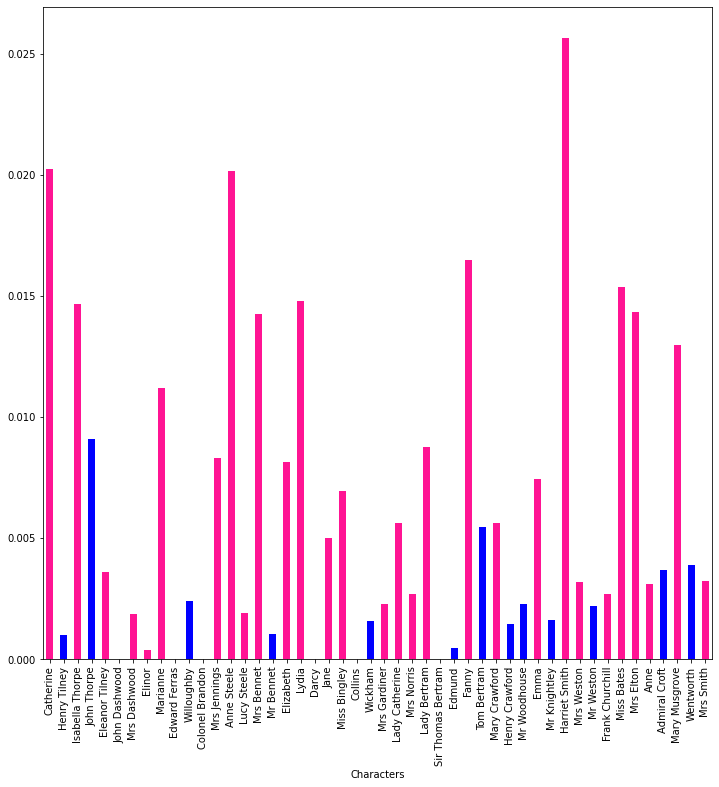

In [351]:
from matplotlib import pyplot as plt

colors = ['deeppink' if val else 'blue' for val in genres]

ax = raw_df['oh'].plot(kind='bar', xlabel='Characters', color=colors, rot=90)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names)
plt.show()

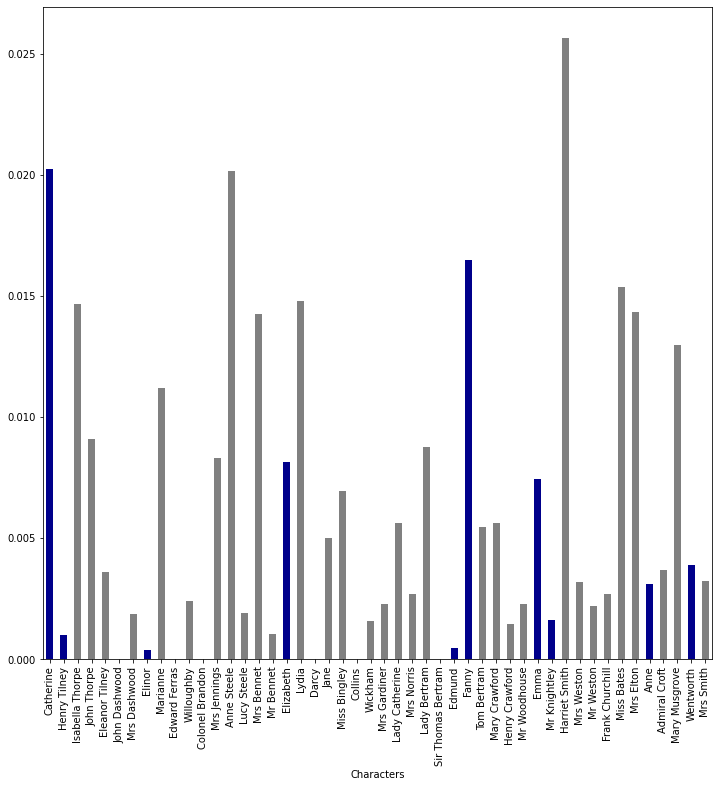

In [330]:
colors = ['darkblue' if val else 'gray' for val in mains]

ax = raw_df['oh'].plot(kind='bar', xlabel='Characters', color=colors, rot=90)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names)
plt.show()

In [340]:
raw_df.loc['3V'].sort_values(ascending=False).head(30)

darcy        0.030207
pride        0.014308
father       0.014308
manner       0.009539
living       0.007949
often        0.007949
late         0.006359
society      0.006359
best         0.006359
part         0.006359
ought        0.006359
fortune      0.006359
opinion      0.006359
certain      0.006359
sort         0.006359
remember     0.004769
many         0.004769
hour         0.004769
bourgh       0.004769
together     0.004769
chuses       0.004769
mention      0.004769
given        0.004769
connected    0.004769
aunt         0.004769
wish         0.004769
seen         0.004769
different    0.004769
agreeable    0.004769
le           0.004769
Name: 3V, dtype: float64

### Clustered heatmap

/opt/homebrew/Caskroom/miniforge/base/envs/data/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/homebrew/Caskroom/miniforge/base/envs/data/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 720x720 with 0 Axes>

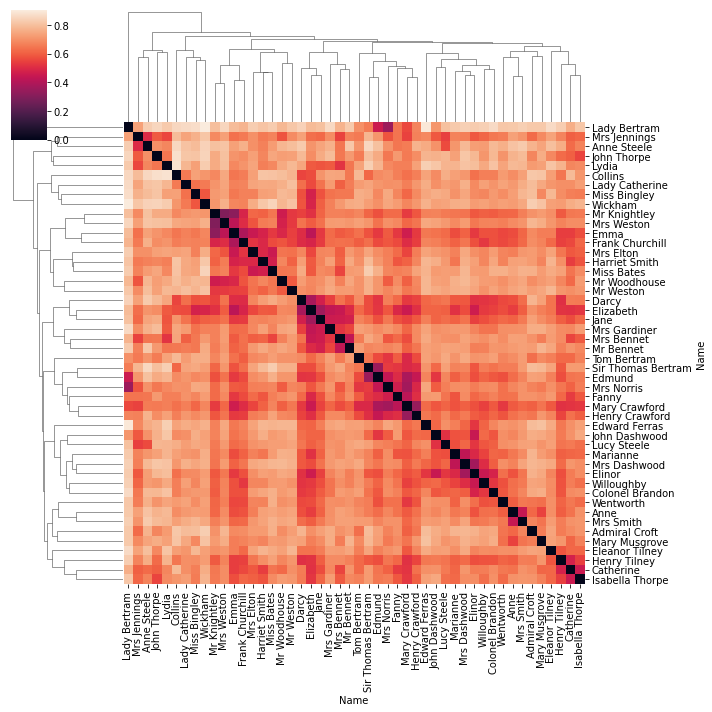

In [349]:
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

data_array = raw_df.to_numpy()
distances = pdist(data_array, metric='cosine')
square_distance_matrix = squareform(distances)
square_distance_df = pd.DataFrame(square_distance_matrix, index=names, columns=names)

from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))

sns.clustermap(square_distance_df, xticklabels=True, yticklabels=True)

plt.show()


---

## Appendix: Extract direct speech

The code below details how the file `austen_dir_speech.txt` was created starting from J.F. Burrow's original annotated text on OTA. The original files were downloaded and stored in the folder: `~/Documents/sync/data/corpora/OTA/Austen_Burrows`.

In [18]:
ja_dir_speech = []

In [19]:

def remove_dollar_comment(text):
    import re
    return re.sub(r'\$.*?\$', '', text)

remove_dollar_comment(mansf[2][1])

NameError: name 'mansf' is not defined

In [ ]:
def pre_process(lines):
    lns = []
    for i,l in enumerate(lines):
        if l.strip() == "" or l.strip() == '~~~':
            continue
        try:
            meta, tx = l.split('|', maxsplit=1)
        except ValueError:
            raise ValueError(f'At line {i}: {l}')
        tx = tx.lstrip(' ').rstrip('\n')
        tx = remove_dollar_comment(tx)
        tx = tx.replace('*', ' ')
        lns.append((meta, tx))
    return lns

def extract_direct_speech(lines, char_code_list, novel_code):
    ds = []
    pattern = re.compile(r'[0-9]([A-Z])[0-9]*\s+!')
    for meta, t in lines:
        match = pattern.search(meta)
        if match:
            char_code = match.group(1)
            if char_code in char_code_list:
                ds.append((f"{novel_code}{char_code}", t, meta))
    return ds

def process_novel(file_name, char_code_list, novel_code):
    dir = os.path.expanduser('~/Documents/sync/data/corpora/OTA/Austen_Burrows')
    with open(os.path.join(dir, file_name)) as f:
        txt = f.readlines()
    lns = pre_process(txt)
    ds = extract_direct_speech(lns, char_code_list, novel_code)
    return ds

In [ ]:
na = process_novel('north-1228.txt', ['A', 'B', 'D', 'E', 'C'], novel_code=1)
ss = process_novel('sense-1224.txt', ['A', 'C','K', 'S', 'F', 'Q', 'H', 'D', 'B', 'P'], novel_code=2)
pp = process_novel('pride-1229.txt', ['A', 'B', 'D', 'E', 'K', 'C', 'O', 'L', 'H', 'J', 'V'], novel_code=3)
mp = process_novel('mansf-1227.txt', ['B', 'C', 'D', 'J', 'A', 'E', 'G', 'F'], novel_code=4)
em = process_novel('emma-1226.txt', ['A', 'B', 'E', 'D', 'I', 'M', 'P', 'O', 'N'], novel_code=5)
pe = process_novel('pers-1230.txt', ['A', 'V', 'P', 'B', 'D'], novel_code=6)

In [ ]:
for n in [na,ss,pp,mp,em,pe]:
    ja_dir_speech.append(n)

In [ ]:
with open('austen_dir_speech.txt', 'w') as out:
    for n in ja_dir_speech:
        for ch,txt,meta in n:
            out.write(f'{ch}\t{txt}\t{meta}\n')


In [ ]:
txt[:5]

["101: 13, 1'  !| No*one who$6#1$ had ever seen $NA#A$Catherine*Morland in her\n",
 "101: 13, 2'  !| infancy, would have supposed her born$1#1$ to$9$ be an heroine.\n",
 "101: 13, 3'  !| Her situation in life, the character of her father and\n",
 "101: 13, 4'  !| mother, her own$2$ person and disposition, were all equally\n",
 "101: 13, 5'  !| against her. Her father was a clergyman, without being$1$\n"]

In [ ]:
len(mansf) == len([t for t in txt if t.strip() != ''])

True

9135

In [ ]:
mansf[10]

("101:  3,11'  !",
 'and such of their acquaintance as thought$1$ $MP#J$Miss*Ward')

In [ ]:
import re

match = re.search(r'[0-9]([A-Z])[0-9]*\s+!', na[i][0])
match.group(1)

'A'